In [6]:
import torch
import cv2 as cv
import numpy as np
from pathlib import Path
import os
import multiprocessing as mp
from shutil import move as mv_file
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import skimage.morphology as morph

In [4]:
torch.has_cuda

True

# Zadanie 1

In [75]:
def read_image(path: str):
    return cv.imread(path)    

def sort_images():
    processes = []
    cwd = Path.cwd().joinpath('Real')
    dest = Path.cwd().joinpath('data')

    for file in Path.iterdir(cwd):
        print(file)
        subject_number = file.name.split('_')[0]
        subject_folder = dest.joinpath(subject_number)
        if not subject_folder.exists():
            subject_folder.mkdir()
        if subject_folder.exists():
            processes.append(mp.Process(target=mv_file, args=(file, dest.joinpath(subject_number).joinpath(file.name))))

    for process in processes:
        process.start() 

    for process in processes:
        process.join() 

def draw_compare(img1, img2):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

In [ ]:
sort_images()

c:\dev\biometry-masters-class\ps4\data\1\1__M_Left_index_finger.BMP c:\dev\biometry-masters-class\ps4\data\1\1__M_Left_little_finger.BMP


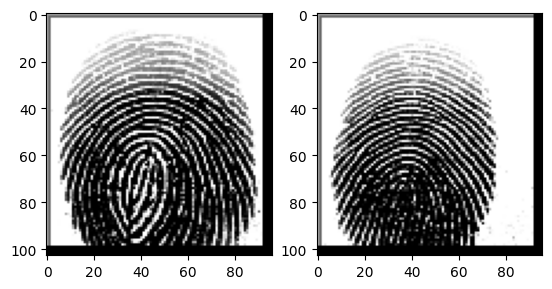

In [8]:
subject_folder_iter = Path.cwd().joinpath('data').joinpath('1').iterdir() 
file_1 = next(subject_folder_iter)
file_2 = next(subject_folder_iter)
print(file_1, file_2)
file_mat_1 = cv.imread(str(file_1))
file_mat_2 = cv.imread(str(file_2))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(file_mat_1)
ax2.imshow(file_mat_2)

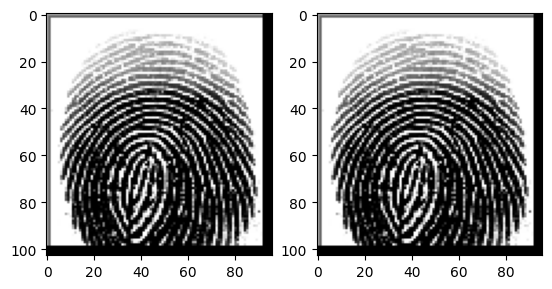

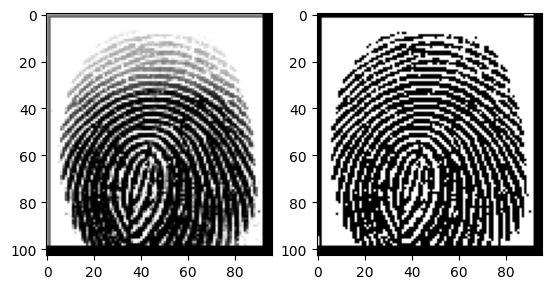

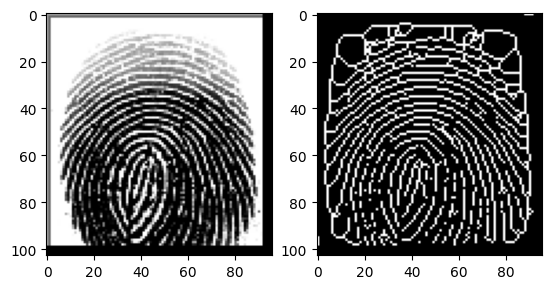

In [161]:
# fingerprint = cv.bitwise_not(file_mat_1)
fingerprint = file_mat_1
draw_compare(file_mat_1, fingerprint)
fingerprint_gray = cv.cvtColor(fingerprint, cv.COLOR_BGR2GRAY)
binarized_img = cv.adaptiveThreshold(fingerprint_gray,1, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
draw_compare(file_mat_1, binarized_img)
fingerprint_skeletonize = morph.skeletonize(binarized_img)
draw_compare(file_mat_1, fingerprint_skeletonize)

{'end_begin': [(42, 14), (39, 16), (42, 22), (69, 22), (64, 36), (13, 37), (50, 38), (63, 38), (67, 38), (37, 39), (52, 39), (35, 40), (65, 41), (75, 41), (76, 44), (59, 46), (76, 46), (41, 47), (47, 47), (49, 47), (55, 47), (71, 47), (19, 49), (58, 49), (78, 51), (31, 54), (14, 56), (42, 56), (44, 56), (71, 56), (33, 57), (13, 58), (28, 58), (19, 60), (32, 60), (41, 60), (57, 60), (21, 61), (30, 62), (54, 62), (25, 63), (52, 63), (59, 63), (29, 64), (54, 64), (20, 66), (24, 66), (55, 66), (46, 67), (55, 67), (61, 67), (80, 67), (58, 68), (23, 69), (19, 70), (46, 70), (55, 70), (58, 70), (23, 71), (26, 71), (54, 71), (18, 72), (58, 72), (66, 72), (31, 73), (62, 73), (54, 74), (67, 74), (26, 75), (30, 75), (50, 75), (58, 75), (62, 75), (83, 75), (22, 76), (26, 76), (77, 76), (18, 77), (37, 77), (71, 77), (81, 77), (49, 78), (57, 78), (58, 78), (84, 78), (54, 79), (69, 79), (72, 79), (18, 80), (27, 80), (78, 80), (34, 81), (45, 81), (57, 81), (66, 81), (69, 81), (72, 81), (85, 81), (18, 

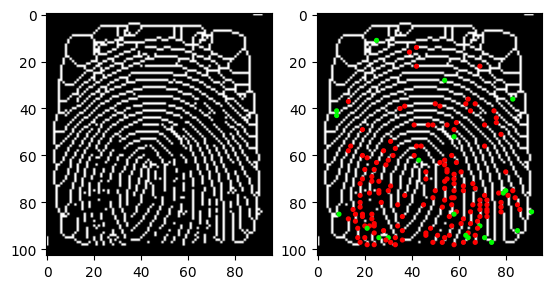

In [167]:
def find_minutae(fingerprint_skeletonize):
    bifurication_kernels = np.array(
            [
            [
                [1,0,0],
                [0,1,0],
                [1,0,0],
            ],
            [
                [1,0,1],
                [0,1,0],
                [0,0,0],
            ],
            [
                [0,0,1],
                [0,1,0],
                [0,0,1],
            ],
            [
                [0,0,0],
                [0,1,0],
                [1,0,1],
            ],
            [
                [0,1,0],
                [0,1,1],
                [0,0,0],
            ],
                    [
                [0,0,0],
                [0,1,1],
                [0,1,0],
            ],
                    [
                [0,0,0],
                [1,1,0],
                [0,1,0],
            ],
                    [
                [0,0,0],
                [0,1,1],
                [0,1,0],
            ]
            ]
        )
    end_begin_kernel = np.array(
    [
            [
                [0,1,0],
                [1,1,1],
                [0,1,0],
            ],
            [
                [1,0,1],
                [0,1,0],
                [1,0,1],
            ]
    ]
        )
    minutae = {
        'end_begin': [],
        'bifurcations':[],
    }
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(fingerprint_skeletonize, cmap='gray')
    ax2.imshow(fingerprint_skeletonize, cmap='gray')
    fingerprint_skeletonize = fingerprint_skeletonize.astype('uint8')
    found_minutiae_img = fingerprint_skeletonize.copy()
    # fingerprint_skeletonize = np.pad(fingerprint_gray, 1)
    X,Y = fingerprint_skeletonize.shape
    for x in range(1, X-1):
        for y in range(1, Y-1):
            # Get kernel for X,Y
            kernel_place = np.array(fingerprint_skeletonize[x-1:x+2,y-1:y+2])

            # Check if kernel has a value in the center
            if kernel_place[1,1]:
                number_of_values = len(np.flatnonzero(kernel_place))
                # Check for beginings and ends
                if number_of_values == 2:
                    if np.flatnonzero(np.bitwise_and(end_begin_kernel[0],kernel_place)).all() and np.flatnonzero(np.bitwise_and(end_begin_kernel[1],kernel_place)).all() :
                        minutae['end_begin'].append((y,x))
                        ax2.add_patch(Circle((y,x), radius=0.8, color='red'))
                #Check for bifurcations
                if number_of_values == 3:
                    for bif_kernel in bifurication_kernels:
                        if len(np.flatnonzero(np.bitwise_and(bif_kernel,kernel_place))) == 3:
                            minutae['bifurcations'].append((y,x))
                            ax2.add_patch(Circle((y,x), radius=0.8, color='lime'))
    return fig, minutae

fig, minutae = find_minutae(fingerprint_skeletonize)
fig.savefig('minutae.jpg')
print(minutae)

In [178]:
def calculate_vector(minutae):
    def calculate_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))
    def calculate_statistics(points_array):
        distance_array = []
        for i in range(len(points_array)):
            for j in range(len(points_array)):
                if (i != j):
                    distance_array.append(calculate_distance(points_array[i], points_array[j]))
        return distance_array
    return calculate_statistics(minutae)

len(calculate_vector(minutae['end_begin']))

24806

- ilosc minucji
- ilosc poczatkow
- ilosc rozwidlen
- stosunek poczatkow/rozwidlen
- srednia odleglosc miedzy minucjami
- maksymalna odleglosc miedzy minucjami
- minimalna odleglosc miedzy minucjami
- mediana odleglosci miedzy minucjami
- srednia odleglosc miedzy poczatkami
- maksymalna odleglosc miedzy poczatkami
- minimalna odleglosc miedzy poczatkami
- mediana odleglosci miedzy poczatkami
- srednia odleglosc miedzy rozwidleniami
- maksymalna odleglosc miedzy rozwidleniami
- minimalna odleglosc miedzy rozwidleniami
- mediana odleglosci miedzy rozwidleniami

In [23]:
best_score = counter = 0
sift = cv.SIFT_create()
keypoints_1, des1 = sift.detectAndCompute(file_mat_1, None)
keypoints_2, des2 = sift.detectAndCompute(file_mat_2, None)

matches = cv.FlannBasedMatcher({'algorithm': 1, 'trees': 10}, {}).knnMatch(
    des1, des2, k=3
)

match_points = []
for p, q, r in matches:
    if p.distance < 0.1 *q.distance:
        match_points.append(p)

In [21]:
for p in keypoints_1:
    ax1.add_patch(Circle(p.pt,radius=0.5))
fig.savefig('hello.png')

In [32]:

keypoints = 0
if len(keypoints_1) <= len(keypoints_2):
    keypoints = len(keypoints_1)
else:
    keypoints = len(keypoints_2)
if len(match_points) / keypoints * 100 > best_score:
    best_score = len(match_points) / keypoints * 100
    filename = file_1
    image = file_mat_1
    kp1, kp2, mp = keypoints_1, keypoints_2, match_points

print("Best match:  " + str(filename))
print("Best score:  " + str(best_score))

if len(match_points) > 0:
    result = cv.drawMatches(file_mat_1, kp1, image, kp2, mp, None)
    result = cv.resize(result, None, fx=5, fy=5)
    image = cv.cvtColor(result, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

Best match:  c:\dev\biometry-masters-class\ps4\data\1\1__M_Left_index_finger.BMP
Best score:  0


# Zadanie 2